# Probabilistic error reduction and virtual Zero-noise extrapolation tutorial notebook
This Notebook shows the complete procedure and implementation of Probabilistic error reduction and virtual Zero-noise extrapolation.

As an illustrative example, the method is applied to a circuit simulation of a transverse field Ising model using Trotter decomposition at various timesteps. However, the notebook is designed to theoretically accommodate other types of circuits as well altho in that case the analysis of the PER would need some adjustments.
The procedure consists of the following steps:
- Decomposing the circuits into layers
- Rebuilding the circuits with noise-scaled gates
- Executing the modified circuits
- Processing the collected data
- Performing zero-noise extrapolation fitting to obtain mitigated results

Although the notebook begins with a Pauli noise tomography to extract noise model coefficients, the tomography procedure itself is not discussed in detail. Instead, it is significantly condensed by utilizing the tomography implementation from the main code. For a more comprehensive understanding, referring to the dedicated tomography notebook beforehand is recommended.

In [110]:
#Here all the needed imports are done. Below the main programms filepath it added to the systempath.
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import Pauli, pauli_basis
from qiskit_aer.noise import NoiseModel, pauli_error
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
from random import choice, choices, random
from scipy.optimize import curve_fit
import math

# This adds the systempath for the "pauli_lindblad_per" folder to the notebook. If the folderstructure is changed, this line needs to be adjusted accordingly
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))
# Import the Tomography header
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")

## Tomography
The backend used is the GenericBackendV2 of qiskit with a linear topography. The Trotter Simulation as given needs at least 4 qubits.

In [111]:
#The number of qubits in our system is set
num_qubits = 4
#With that number a coupling map is created. It can be choosen to be whatever desired. 
#Right now is does a linear coupling map with connections forwards [0,1](first bracket) and backwards [1,0](last bracket). 
#The implementation of the linear coupling here is flexable to work with any qubit count
coupling_map = [[i,i+1] for i in range(num_qubits-1)]+[[i+1,i] for i in range(num_qubits-1)] 
#This is then used to create the backend
backend = GenericBackendV2(num_qubits=num_qubits, coupling_map=coupling_map)

The noise model is constructed using the same methodology as described in the tomography notebook.

In [112]:
if True: # When set to 'True', a preset noisemodel will be choosen. When set to 'False', the noise model will be randomized on every run
	# The kind of Pauli error is choosen
	twoqubit_errorops = [Pauli('XY')] 
	# The respective chance for the Pauli errors is choosen. The two lists need to be equal in length
	twoqubit_errorprobs = [0.05] 

	# This is the same for single qubit gate errors
	singlequbit_errorops = [Pauli('X')] 
	singlequbit_errorprobs = [1]
else:
	# A random number of errors is choosen
	num = choices([3,4,5,6,7,8])[0]
	# Random Paulis are choosen. The random paulis can be duplicate and be the identity, so don't wonder when you get less the choosen number errors
	twoqubit_errorops = choices(pauli_basis(2), k=num)
	# Assign random probabilities
	twoqubit_errorprobs = [random()*.1/num for op in twoqubit_errorops] 

	# This is the same for single qubit gate errors
	num = choices([3,4,5,6,7,8])[0]
	singlequbit_errorops = choices(pauli_basis(1), k=num)
	singlequbit_errorprobs = [random()*.1/num for op in singlequbit_errorops]
# Create *normalized* error model.
twoqubit_error_template = [(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))]
twoqubit_error = pauli_error(twoqubit_error_template)
singlequbit_error_template = [(op, p) for op,p in zip(singlequbit_errorops, singlequbit_errorprobs)]+[(Pauli("I"), 1-sum(singlequbit_errorprobs))]
singlequbit_error = pauli_error(singlequbit_error_template)



noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
#add error model to single-qubit gates. Comment the next line in if single qubit errors are wanted!
#noise_model.add_all_qubit_quantum_error(singlequbit_error, ['id','rz','sx'])

The first function in the next block constructs one layer of the trotter decomposition, while the second function concatenates multiple layers into one circuit. To show the effectiveness of PER on circuits with accumulating error, 14 circuits are build with increasing amounts trotterlayers.

In [113]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1 
J = -.15
dt = .2 # time stepsize
n = 2 # amount of qubits halfed

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    #trotterCircuit = transpile(trotterCircuit, backend) # transpiling swaps gates for backend native gates and optimizes the code by removing and combining unnessesary gates
    return trotterCircuit

circuits = [maketrotterCircuit(i) for i in range(1,15)]
circuits[0].draw(fold=-1)

┌─────────┐                                             ░ 
q_0: ┤ Rx(0.8) ├──■────────────────■─────────────────────────░─
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐                       ░ 
q_1: ┤ Rx(0.8) ├┤ X ├┤ Rz(0.12) ├┤ X ├──■────────────────■───░─
     ├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐ ░ 
q_2: ┤ Rx(0.8) ├──■────────────────■──┤ X ├┤ Rz(0.12) ├┤ X ├─░─
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘ ░ 
q_3: ┤ Rx(0.8) ├┤ X ├┤ Rz(0.12) ├┤ X ├───────────────────────░─
     └─────────┘└───┘└──────────┘└───┘                       ░

The executer function runs all circuits given to on the backend provided with the amount of shots and noise model given and returns the counts.
Experiment class requires this to be given to it, to be able to flexably adjust to different backends.
The function is keeped very simple here, but can be as adaptiv as needed. In the main code "TrotterExample.py", this is used to change between different backends as per user input.

In [114]:
def executor(circuits, backend, shots, noise_model=None):
	return backend.run(circuits, shots=shots, noise_model = noise_model).result().get_counts()

Initialize the tomography procedure

In [115]:
experiment = tomography(circuits = circuits, inst_map = [i for i in range(backend.num_qubits)], backend = backend)

Generate the PNT Circuits

In [116]:
experiment.generate(samples = 32, single_samples = 200, depths = [2,4,8,16])

Run the PNT Circuits

In [117]:
experiment.run(executor, shots=1024, noise_model=noise_model)

Analyze the PNT Circuits

In [118]:
noisedataframe = experiment.analyze()

The Tomography creates one set of noisemodel coefficients for every unique cliff layer (explained below) in any circuit. For better showcasing, these coefficients and the functions (shown later) are extracted.
Additionally, the SPAM coefficient, which is universal, is also extracted.

In [119]:
local_noisemodels = {str(key):[(pauli.pauli, value) for pauli, value in noisedataframe.noisemodels[key].coeffs] for key in noisedataframe.noisemodels}
spam = noisedataframe.spam # Save the universal spam coefficient of the system

## PER
### Decomposing the circuits into layers
Since the noise has to be altered at the noisy gate, the circuits need to be seperated into layers. A layer consists of all gates in the circuits up until the first appearence of the noisy gate, which are 2-qubit gates in this notebook. These gates, plus the noise gate and all other noisy gates that execute in paralell to the first appearing one, are then saved as a seperate circuit. The indivial gate types are also saved seperately in the metadata as `single_layer` for all non noisy gates, and `cliff_layer` for the noisy ones.

In [120]:
# Cut into layers
layered_circuits = [] # This is where the splitup circuits will be saved in

def separate_gates(layer, weight : int):
	"""This method parses the list of gates in the input layer and returns a Circuit
	consisting only of gates with the desired weight"""

	qc = layer.copy_empty() 
	for inst in layer:
		if inst.weight() == weight:
			qc.add_instruction(inst)
	return qc

noisemodels = {str(key): noisedataframe.noisemodels[key] for key in noisedataframe.noisemodels}

for qc in circuits:
	layers = []
	inst_list = [inst for inst in qc if inst.name != "measure"] # get list of instruction exept for the measurement instruction

	#pop off instructions until inst_list is empty
	while inst_list:

		circ = qc.copy_empty_like() #blank circuit to add instructions
		layer_qubits = set() #qubits in the support of two-qubit clifford gates

		for inst in inst_list.copy(): #iterate through remaining instructions
				#print(inst)
			#check if current instruction overlaps with support of two-qubit gates
			#already on layer
			if not layer_qubits.intersection(inst.qubits) and (len(inst.qubits) == 2 or len(layer_qubits) == 0):
				circ.append(inst) #add instruction to circuit and pop from list
				inst_list.remove(inst)

			if len(inst.qubits) == 2:
				layer_qubits = layer_qubits.union(inst.qubits) #add support to layer
		from primitives.circuit import QiskitCircuit
		if separate_gates(QiskitCircuit(circ), 2) != []: #append only if not empty
			circ.metadata["single_layer"] = separate_gates(QiskitCircuit(circ), 1)
			circ.metadata["cliff_layer"] = separate_gates(QiskitCircuit(circ), 2)
			circ.metadata["noisemodel"] = local_noisemodels.get(str(circ.metadata["cliff_layer"]), None)#local_noisemodels.get(str(circ.metadata["cliff_layer"]), None) # Get the noise model, that belong to the layer
			circ.metadata["qc"] = qc
			layers.append(circ) # Save the layer
	layered_circuits.append(layers)

The 3 values that need to be choosen for the PER run are:
- To what noise strengths should the altered. 0 is equal to PEC while 1 is unmitigated.
- Which expectation values should be recorded. 
- How many samples should be made per measurement basis for every circuit. The total circuit count is distributed to the different noise strengths to obtain the same accuracy as closely as possible for all stengths, while maintaining a minimum samplesize.

In [ ]:
# Tipp: Try if it runs first with fewer samples. 100 samples * 4 noise strengths * 1 meas basis takes about 12 minutes on a AMD Ryzen 5 2600
noise_strengths = [0,0.5,1,2]
# The length of the string has to be equal to the number of qubits. The strings can be put in exaclty if the backend size is known. 
# For this example the string adapts to be longer with the `"I"*(num_qubits-4)` so the programm runs even for a bigger backend.
expectations = ["ZIII"+"I"*(num_qubits-4),"IZII"+"I"*(num_qubits-4),"IIZI"+"I"*(num_qubits-4),"IIIZ"+"I"*(num_qubits-4)]
samples_per_circuit = 5000 # This should be at about 1000 to obtain good result. Fewer might work depending on input circuit.

As some expecation values can be measured in paralell, the wanted expectation values are tried to be compressed into as few measurement basis as possible

In [148]:
def get_composite(pauli1, pauli2): # Example input: "IZII", "IIIZ" Output: "IZIZ"
	label1 = pauli1.to_label()
	label2 = pauli2.to_label()
	comp = ["I"]*max([len(label1),len(label2)])
	for i, (l1,l2) in enumerate(zip(label1, label2)):
		c = l1
		if l1 == "I":
			c = l2
		comp[i] = c
	return Pauli("".join(comp))

meas_bases = []
#iterate through expectations
expectations = [Pauli(ex) for ex in expectations]
for pauli in expectations:
	for i,base in enumerate(meas_bases): #iterate through bases
		if all([p1==p2 or p1 == Pauli("I") or p2 == Pauli("I") for p1,p2 in zip(base, pauli)]): #if nonoverlapping, compose into last basis
			meas_bases[i] = get_composite(base, pauli)
			break
	else:
		meas_bases.append(pauli) #if no break is reached, append to end

The noisemodel saves the coefficients at the unmitigated point, meaning they need to be altered to the intended noise strength. The `init_tuning` function does this, as well is calculate the overhead.
The `sample` function return a random pauli operator based on the probabilites provided

In [149]:
def init_tuning(coeffs, strength):
	"""Noise scaling is cast as a specific case of a more general noise tuning, which is
	is implemented here"""

	new_coeffs =  dict([(term, strength*coeff) for term,coeff in coeffs])
	new_probs = []

	#sample p_k with probability w_k^{phi-lambda}, change sign if phi_k < lambdak
	for pauli, lambdak in coeffs:
		phik = new_coeffs.get(pauli, 0)
		new_prob = .5*(1-np.exp(-2*abs(phik-lambdak)))
		if strength == 1 and new_prob != 0:
			print(lambdak, phik, new_prob)
		sgn = 0

		if phik < lambdak:
			sgn = 1
		new_probs.append((pauli, new_prob, sgn))
	
	#compute overhead as the product of overheads of terms which are downscaled 
	overhead = 1
	for pauli, lambdak in coeffs:
		phik = new_coeffs[pauli]
		if phik < lambdak:
			overhead *= np.exp(2*(lambdak-phik))
	return (new_probs, overhead)

def pauli_mul(pauli, pauli2):
        result = pauli.compose(pauli2)
        return Pauli((result.z, result.x)) # nophase

def sample(probs, num_qubits):
	"""Sample from the QPD representation of the partial inverse and return the sign."""

	operator = Pauli("I"*num_qubits)
	sgn_tot = 0
	
	for term, prob, sgn in probs:
		if random() < prob: #sample with probability prob
			operator = pauli_mul(operator, term) #compose into product
			sgn_tot ^= sgn #record sign

	return operator, sgn_tot

### Rebuilding the circuits with noisescaled gates
The circuits that where taken appart are being reconstructed. Layer by layer the `single_layer` gates are entered into the circuit after which the noisescaling gates are added followed by the `cliff_layer`.
The number of samples per circuit, that was given, is being distributed across all noise strengths, weighted by needed number of circuits at same accuracy according to Monte Carlo estimation. The only exception is, that a minimum number of circuits need to run for every strengths because of the twirling. So if checks that and accounts for it in the distribution.

In [ ]:
def conjugate(qc, pauli : Pauli):
	pauli_c = pauli.evolve(qc)
	return Pauli((pauli_c.z, pauli_c.x))

def basis_change(pauli, qc):
	circ = qc.copy_empty_like()
	for p,q in zip(pauli, qc.qubits):
		if p == Pauli("X"):
			circ.qc.h(q)
		elif p == Pauli("Y"):
			circ.qc.h(q)
			circ.qc.s(q)

	return circ

def calculate_gamma_scale(pcirc):
	# Calculate gamma for every noise strength
	gammas = []
	for noise_strength in noise_strengths:
		gamma = 1
		if noise_strength < 1:
			for layer in pcirc:
				gamma *= np.exp(2*(1-noise_strength)*sum([abs(value[1]) for value in layer.metadata["noisemodel"]])) # Equation in chapter "PER with Pauli Twirling"
		gammas.append(gamma)
	# Distribute and create scale. Round to nearest int number
	samples_scale = {noise_strength: round(samples_per_circuit*gamma/sum(gammas)) for noise_strength, gamma in zip(noise_strengths, gammas)}
	# To make sure all circuits have a minimum number of circuits, check for noise_strengths with lower counts and set them higher, without increasing the overall sample count
	marked = [] # Save all the noise_strengths that need to be set to the minimum
	# This is a temporary figure. The number needs to be big enougth to account for the twirling precision. Once a definitive answer is figured out, it comes here
	minimum_circuit_count = max(samples_per_circuit/(2.5*len(noise_strengths)),1) # Define the minimum
	new_marked = True #loop has to run at least one. Python does not have a do while loop
	while new_marked:
		new_marked = False
		for key in samples_scale:
			if samples_scale[key] < minimum_circuit_count: # Check all sample sizes
				new_marked = True # And mark the one that are to low
				marked.append(key) 
		if new_marked: # Recalculate the scale with the min number of circuits for every marked strength taken of the pool, for the rest of the strengths
			samples_scale = {noise_strength: round((samples_per_circuit-len(marked)*(minimum_circuit_count))*gamma/sum([gamma for noise_strength, gamma in zip(noise_strengths, gammas) if noise_strength not in marked])) for noise_strength, gamma in zip(noise_strengths, gammas) if noise_strength not in marked}
		# Loop until nothing more gets marked
	for mark in sorted(marked): # Add the marked back at the minimum count
		samples_scale[mark] = round(minimum_circuit_count)
	return samples_scale

per_runs = []
for pcirc in layered_circuits:
	samples_scale = calculate_gamma_scale(pcirc)
	for basis in meas_bases:
		for noise_strength in noise_strengths:
			for _ in range(samples_scale[noise_strength]):
				circ = QuantumCircuit(4)
				sgn_tot = 0
				overhead = 1
					
				#Sample from each layer and compose together 
				for layer in pcirc:
					(probs, temp_overhead) = init_tuning(layer.metadata["noisemodel"], noise_strength)  #set up coefficients for sampling
					circ = circ.compose(layer.metadata["single_layer"].qc) #compose single-qubit layer
					circ.barrier()
					twirl = Pauli("".join(choices("IXYZ", k=circ.num_qubits))) #generate a random pauli
					for q,p in zip(circ.qubits, twirl): # add_pauli
						circ.append(p, [q])

					op, sgn = sample(probs, layer.metadata["cliff_layer"].qc.num_qubits) #sample from noise and record sign
					for q,p in zip(circ.qubits, op): # add_pauli
						circ.append(p, [q])

					circ = circ.compose(layer.metadata["cliff_layer"].qc)

					#invert pauil twirl and compose into next layer for consistent noise
					for q,p in zip(circ.qubits, conjugate(layer.metadata["cliff_layer"].qc, (twirl))): # add_pauli
						circ.append(p, [q])
					sgn_tot ^= sgn
					overhead *= temp_overhead
					circ.barrier()

				#implement basis change and readout twirling
				circ = circ.compose(basis_change(basis, circ).inverse()) # basis_change
				readout_twirl = Pauli("".join(choices("IX", k=circ.num_qubits)))
				rostring = readout_twirl.to_label()
				for q,p in zip(circ.qubits, readout_twirl): # add_pauli
					circ.append(p, [q])
				circ.measure_all()
				#circ = transpile(circ, backend)

				circ.metadata = pcirc[0].metadata.copy()
				circ.metadata["sgn_tot"] = sgn_tot
				circ.metadata["overhead"] = overhead
				circ.metadata["rostring"] = rostring
				circ.metadata["basis"] = basis
				circ.metadata["noise_strength"] = noise_strength

				per_runs.append(circ)

{0: 430, 0.5: 313, 1: 228, 2: 228}
{0: 573, 0.5: 304, 1: 162, 2: 162}
{0: 692, 0.5: 268, 1: 120, 2: 120}
{0: 749, 0.5: 211, 1: 120, 2: 120}
{0: 796, 0.5: 164, 1: 120, 2: 120}
{0: 835, 0.5: 125, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}
{0: 840, 0.5: 120, 1: 120, 2: 120}


For comparison, the next block shows the original circuit next to one PER Circuits for both fully mitigated noise and unmitigated noise

In [181]:
print("Original Circuit:")
print(circuits[0].draw(fold=-1))

print("\nPER Circuit with fully mitigated noise:")
for run in per_runs:
    if run.metadata["qc"] == circuits[0] and run.metadata["noise_strength"] == 0:
        print(run.draw(fold=-1))
        break
    
print("\nPER Circuit with unmitigated noise:")
for run in per_runs:
    if run.metadata["qc"] == circuits[0] and run.metadata["noise_strength"] == 1:
        print(run.draw(fold=-1))
        break

Original Circuit:
     ┌─────────┐                                             ░ 
q_0: ┤ Rx(0.8) ├──■────────────────■─────────────────────────░─
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐                       ░ 
q_1: ┤ Rx(0.8) ├┤ X ├┤ Rz(0.12) ├┤ X ├──■────────────────■───░─
     ├─────────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐ ░ 
q_2: ┤ Rx(0.8) ├──■────────────────■──┤ X ├┤ Rz(0.12) ├┤ X ├─░─
     ├─────────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘ ░ 
q_3: ┤ Rx(0.8) ├┤ X ├┤ Rz(0.12) ├┤ X ├───────────────────────░─
     └─────────┘└───┘└──────────┘└───┘                       ░ 

PER Circuit with fully mitigated noise:
        ┌─────────┐ ░ ┌───┐┌───┐     ┌───┐ ░              ░ ┌───┐┌───┐     ┌───┐ ░  ░ ┌───┐┌───┐┌───┐      ░              ░ ┌───┐┌───┐┌───┐      ░ ┌───┐ ░ ┌─┐         
   q_0: ┤ Rx(0.8) ├─░─┤ X ├┤ I ├──■──┤ X ├─░──────────────░─┤ Y ├┤ I ├──■──┤ Y ├─░──░─┤ X ├┤ I ├┤ X ├──────░──────────────░─┤ X ├┤ I ├┤ X ├──────░─┤ X ├─░─┤M├─────────
        ├─────────┤ ░ ├───┤├─

### Executing the modified circuits

In [182]:
counts = executor(per_runs, backend, 1024, noise_model)

### Processing the collected data
The calculation of the expectation value here is identical to the tomography notebook, with the only exception being that the readout twirl is done in a seperate function.

In [183]:
def untwirl_result(run, result):
	"""Return a dictionary of results with the effect of the readout twirling accounted for.
	"""
	if not result:
		raise Exception("No results added")

	ro_untwirled = {}
	rostring = run.metadata["rostring"]
	for key in result:
		newkey = "".join([{'0':'1','1':'0'}[bit] if flip=="X" else bit for bit,flip in zip(key,rostring)])
		ro_untwirled[newkey] = result[key]
	return ro_untwirled 

def get_expectation(run, pauli, result):
	"""Return the expectation of a pauli operator after a measurement of the circuit,
	adjusting the result for the readout twirling"""

	estimator = 0
	result = untwirl_result(run, result)
	#compute locations of non-idetity terms (reversed indexing)
	pz = list(reversed([{Pauli("I"):'0'}.get(p,'1') for p in pauli]))
	#compute estimator
	esti_array = []
	for key in result.keys():
		#compute the overlap in the computational basis
		sgn = sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pz, key)])
		#update estimator
		estimator += (-1)**sgn*result[key]
		esti_array.append((-1)**sgn*result[key])
	return (estimator/sum(result.values())) * run.metadata["overhead"] * ((-1)**run.metadata["sgn_tot"])

def get_spam(pauli):
	"""Returns the absolut spamvalue for a specific pauli"""
	full_spam = 1 
	for i,p in enumerate(pauli): 
		b = Pauli("I"*num_qubits)
		b[i] = p
		if b != Pauli("I"*num_qubits):
			full_spam *= spam[b]
	return full_spam

Sort the executed circuits by their originating circuit into seperate arrays

In [184]:
runs_sorted_by_circ = []
for circ in circuits:
	runs = []
	for i, run in enumerate(per_runs):
		if run.metadata["qc"] == circ:
			runs.append((run, counts[i]))
	runs_sorted_by_circ.append(runs)

For all circuits the expectation values are calculated and averaged over all samples and measurement basis (that can feed into the expectation value). 
In addition, the individual expectation values are separately collected in the `dataStatistic` entry for error propagation and display.

In [185]:
circuit_results = []
for runs in runs_sorted_by_circ:
	data = {} #keys are expectations
	sim_meas = {}

	for run, count in runs:
		if not run.metadata["basis"] in sim_meas:
			expecs = []
			for pauli in expectations:
				if all([p1==p2 or p2 == Pauli("I") for p1,p2 in zip(run.metadata["basis"], pauli)]): #simultaneous
					expecs.append(pauli)
			sim_meas[run.metadata["basis"]] = expecs

		for basis in sim_meas[run.metadata["basis"]]:
			if not basis in data:
				data[basis] = {"spam": get_spam(basis), "data": {}, "dataStatistic": {}, "counts": {}}

			strength = run.metadata["noise_strength"]
			expectation = get_expectation(run, basis, count) #get mitigated, untwirled expectation value

			expectation /= data[basis]["spam"]

			#update estimator of expectation value
			data[basis]["data"][strength] = data[basis]["data"].get(strength, 0) + expectation

			#Gather all entries for futher analysis like error
			if data[basis]["dataStatistic"].get(strength, []) == []:
				data[basis]["dataStatistic"][strength] = [expectation]
			else:
				data[basis]["dataStatistic"][strength] += [expectation]
			
			data[basis]["counts"][strength] = data[basis]["counts"].get(strength, 0)+1
	circuit_results.append(data)

### Performing zero-noise extrapolation fitting to obtain mitigated results

In [ ]:
for data in circuit_results:
	for perdat in data.values():
		expfit = lambda x,a,b: a*np.exp(b*x)
		try:
			popt, pcov = curve_fit(
				expfit, list(sorted(perdat["data"].keys())), 
				[perdat["data"][s]/perdat["counts"][s] for s in list(sorted(perdat["data"].keys()))], 
				bounds = [(-1.5, -1),(1.5,0)], #b > 0 is enforced. Technically |a| <= 1 could also be enforced
				#to improve the accuracy, but this feels a bit like cheating 
				sigma=[np.std(perdat["dataStatistic"][strength]) for strength in list(sorted(perdat["data"].keys()))], #Factor in the error of the data for the error of the fit
				absolute_sigma=True
				)
		except:
			raise Exception("Fitting failed. Probably not enough data points!")
		gammas,b = popt
		perdat["expectation"] = gammas
		perdat["expectation_error"] = math.sqrt(pcov[0][0])
		perdat["b"] = b # This value is only need to display the individual fit curves at the end

{'spam': np.float64(0.9996988963683076), 'data': {0: np.float64(292.0809389411222), 0.5: np.float64(220.4246227664213), 1: np.float64(142.9668759705664), 2: np.float64(124.23858056280383)}, 'dataStatistic': {0: [np.float64(1.2098788657428932), np.float64(-1.2723954028785442), np.float64(-1.2503307427130204), np.float64(1.2062014223819726), np.float64(1.1657495454118454), np.float64(1.1767818754946073), np.float64(1.242975855991179), np.float64(1.1878142055773695), np.float64(-1.1657495454118454), np.float64(1.158394658690004), np.float64(1.1510397719681629), np.float64(1.1914916489382898), np.float64(1.2062014223819726), np.float64(1.1436848852463215), np.float64(1.1694269887727662), np.float64(1.1363299985244804), np.float64(1.158394658690004), np.float64(-1.242975855991179), np.float64(1.2245886391865757), np.float64(1.1878142055773695), np.float64(-1.1510397719681629), np.float64(1.1694269887727662), np.float64(1.1951690922992106), np.float64(1.2503307427130204), np.float64(1.224588

Get the extrapolated results of all circuits in only array for display.
The same is done for their errors, and all the measurement results at different levels of noise and their respective errors.

In [187]:
results = []
results_errors = []
results_at_noise = []
results_at_noise_errors = []
j = 0
for data in circuit_results:
	tot = 0
	tot_error = 0
	tot_at_noise = [0 for _ in range(len(noise_strengths))]
	tot_at_noise_errors = [0 for _ in range(len(noise_strengths))]
	for op in expectations:
		#get the full per results
		expec = data[op]["expectation"]
		tot += expec/len(expectations)

		#get the corresponding fit-errors
		expec_error = data[op]["expectation_error"]
		tot_error += expec_error/len(expectations)

		#get the value at the different noise levels
		expec_at_noise = [data[op]["data"][s]/data[basis]["counts"][s] for s in noise_strengths]
		for i in range(0,len(tot_at_noise)):
			tot_at_noise[i] += expec_at_noise[i]/len(expectations)

		#get the corresponding errors of the values at the different noise levels
		expec_at_noise_error = [np.std(data[op]["dataStatistic"][strength]) for strength in noise_strengths]
		for i in range(0,len(tot_at_noise)):
			tot_at_noise_errors[i] += expec_at_noise_error[i]/len(expectations)

	results.append(tot)
	results_errors.append(tot_error)
	results_at_noise.append(tot_at_noise)
	results_at_noise_errors.append(tot_at_noise_errors)
	j+=1
results[4]

np.float64(-0.5098168460718477)

Calculate the unmitigated and ideal results.

In case a different backend was used, a simulated backend can be reintroduced to simulate the ideal outcome and the outcome of the entered noisemodel.
Make sure to adjust the coupling map to reflect the prior backend. 

Unmitigated results may also be done via prior backend if wished.

In [188]:
#coupling_map = [[i,i+1] for i in range(num_qubits-1)]+[[i+1,i] for i in range(num_qubits-1)] 
#backend = GenericBackendV2(num_qubits=num_qubits, coupling_map=coupling_map)

noisyresult = []
res = []
for i in range(2):
	for circ in circuits:
		qc = circ.copy()
		qc.measure_all()
		if i == 0: # Ideal results
			count= backend.run(qc, shots = 1024, noise_model=None).result().get_counts()
		else: # Unmitigated results
			count= backend.run(qc, shots=1024, noise_model=noise_model).result().get_counts()
		count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
		tot = 0
		for key in count.keys():
			num = sum([(-1)**bit for bit in key[:4]])
			tot += num*count[key]
		if i == 0: # Ideal results
			res.append(tot/(1024*n*2))
		else: # Unmitigated results
			noisyresult.append(tot/(1024*n*2))

## Display Results
The next code block plots the results from the PER/vZNE. It makes multiple plots, One with the errors at the vZNE results, and one with the errors at one noise level each.

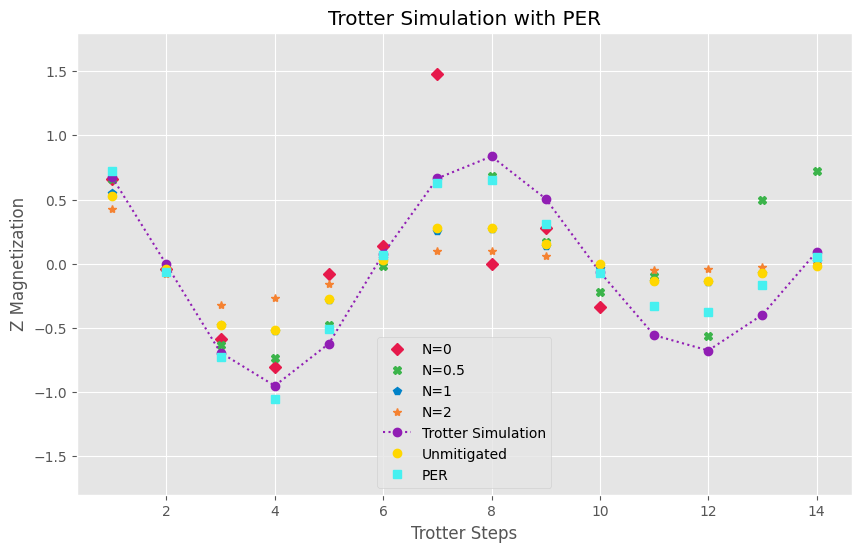

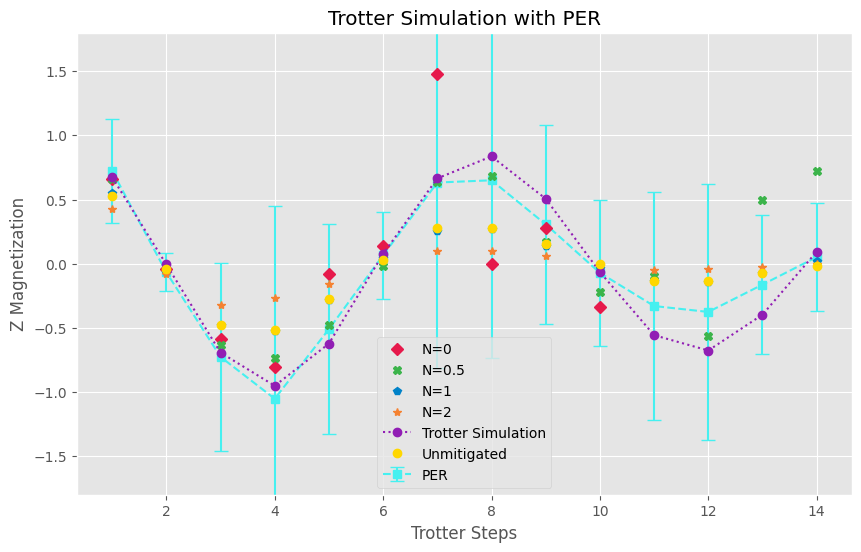

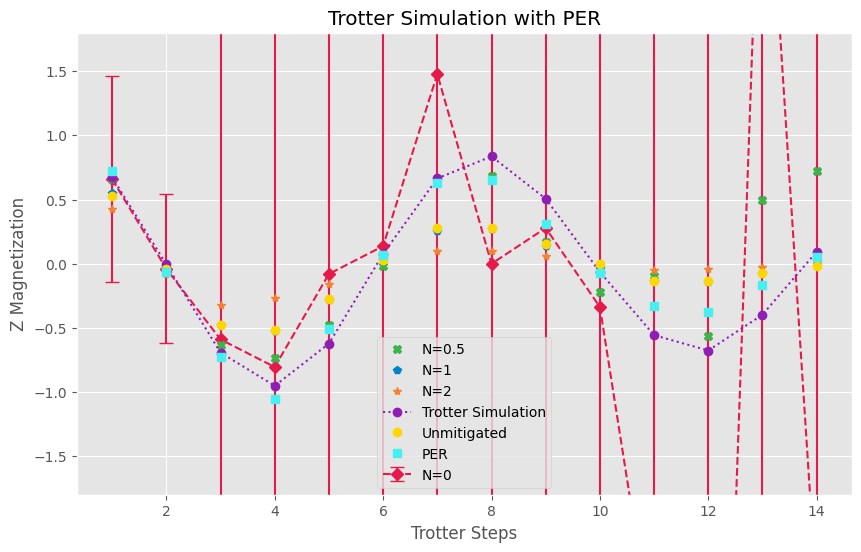

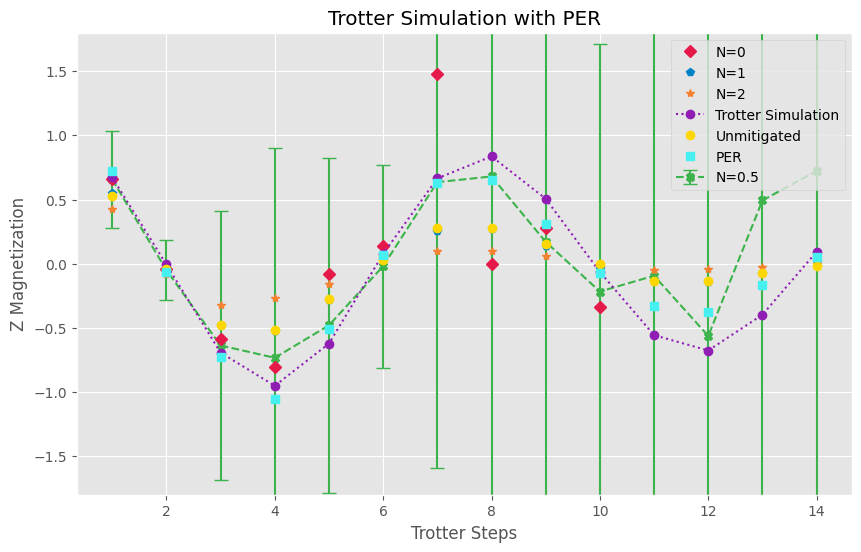

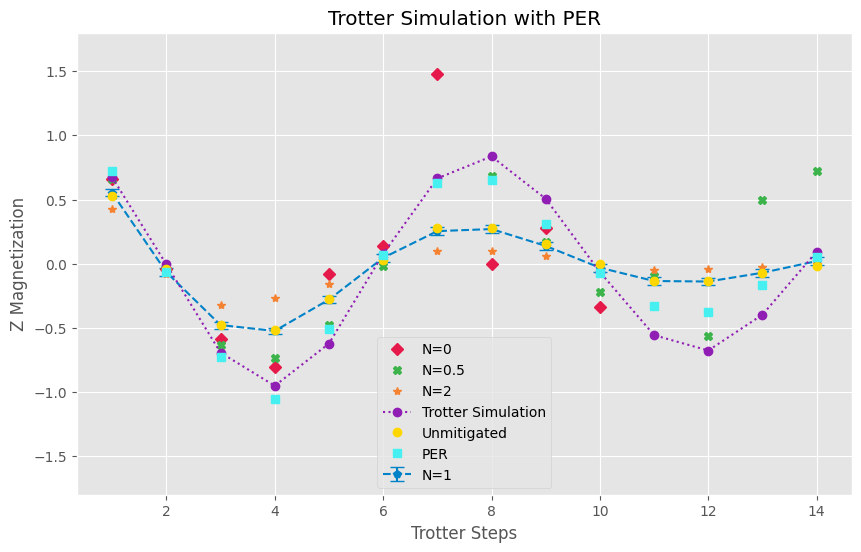

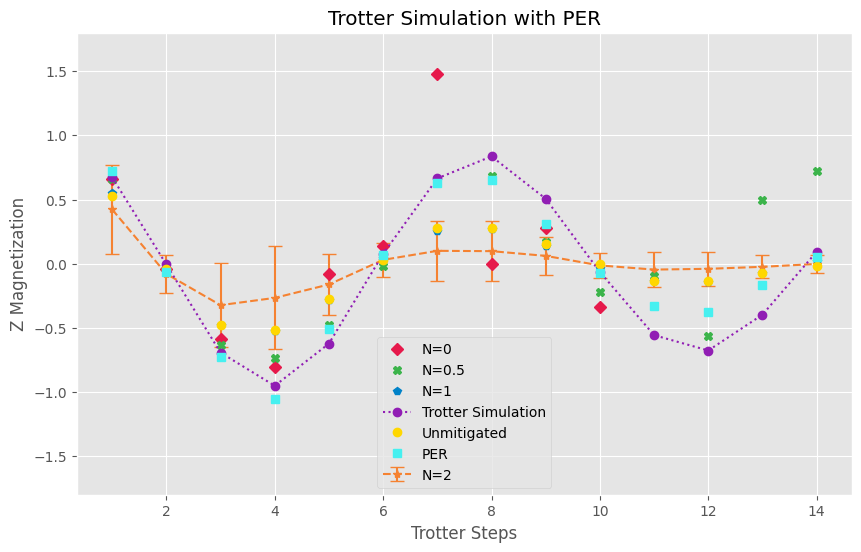

In [ ]:
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = ['#E6194B', '#3CB44B', '#0082C8', '#F58231', '#911EB4', '#FFD700', '#46F0F0', '#F032E6', '#A9A9A9']

markers = ['D', 'X', 'p', '*']

for j in range(len(noise_strengths)+2): # 0 vZNE results, 1-x results at noise level
	plt.figure(figsize=(10,6))
	for i, noise in enumerate(noise_strengths):
		if j != 0 and j!= 1 and noise == noise_strengths[j-2]:
			plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt=markers[i]+'--', yerr=[res[i] for res in results_at_noise_errors], capsize=5, label='N='+str(noise), color= colors[i], zorder=1)
		else:
			plt.plot(range(1,15), [res[i] for res in results_at_noise], markers[i], label='N='+str(noise), color= colors[i], zorder=2)
		
	plt.plot(range(1,15), res, 'o:', label="Trotter Simulation", color= colors[len(noise_strengths)], zorder=2)
	plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated", color= colors[len(noise_strengths)+1], zorder=2)
	if j == 1:
		plt.errorbar(range(1,15), results, yerr=[[np.abs(res) for res in results_errors]],fmt='s--', capsize=5, label="PER", color= colors[len(noise_strengths)+2], zorder=1)
	else:
		plt.plot(range(1,15), results, 's', label="PER", color= colors[len(noise_strengths)+2], zorder=2)

	plt.ylim([-2.1,2.1])
	plt.legend()
	plt.title("Trotter Simulation with PER")
	plt.xlabel("Trotter Steps")
	plt.ylabel("Z Magnetization")
	#plt.savefig("Trotter_Sim_PER.png")
	plt.show()

In [190]:
expectations

[Pauli('ZIII'), Pauli('IZII'), Pauli('IIZI'), Pauli('IIIZ')]

This code block displays the vZNE fit for every Expectation value.

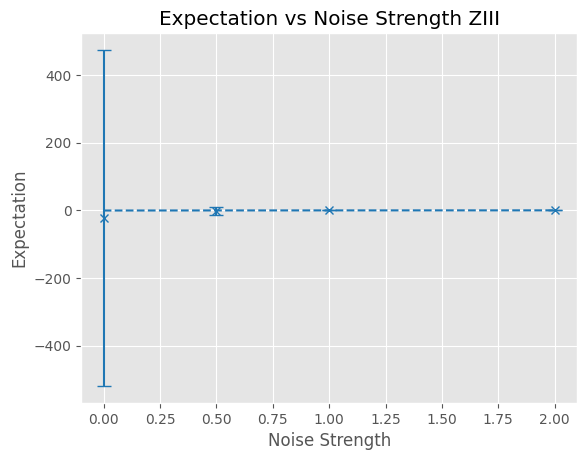

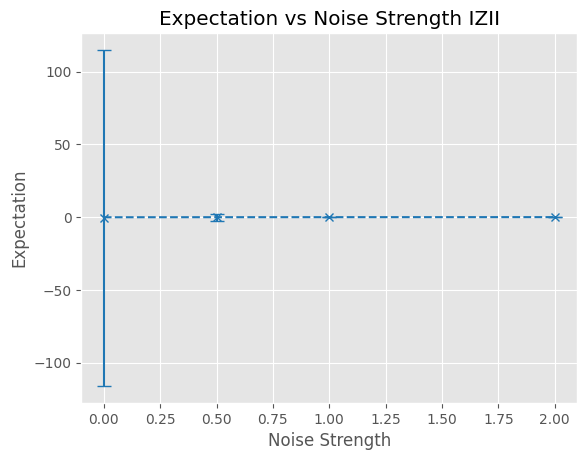

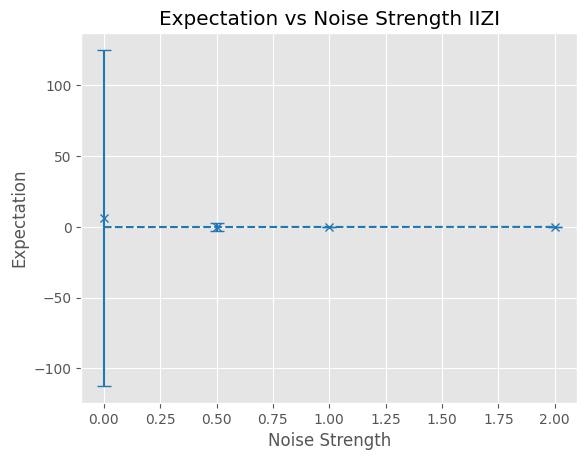

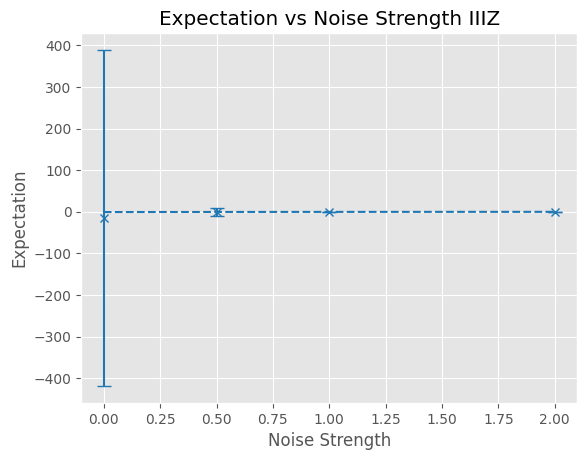

In [ ]:
def plot(perdat):
	"""Plots the expectation values against an exponential fit.
	"""
	fig, ax = plt.subplots()
	ax.errorbar(list(sorted(perdat["data"].keys())), [perdat["data"][s]/perdat["counts"][s] for s in list(sorted(perdat["data"].keys()))], yerr=[np.std(perdat["dataStatistic"][strength]) for strength in list(sorted(perdat["data"].keys()))],  linestyle = "None", marker = "x", color = "tab:blue", capsize=5)
	a = perdat["expectation"]
	b = perdat["b"]
	xlin = np.linspace(0, max(list(sorted(perdat["data"].keys()))), 100)
	ax.plot(xlin, [a*np.exp(b*x) for x in xlin], color = "tab:blue", linestyle="--")
	
for ex in expectations:
	# Change the number in circuit_results[NUMBER] to show different circuits fits
	ax = plot(circuit_results[11].get(ex, None))
	# If the error becomes to big, uncomment the next line to still see anything but a straight line
	#plt.ylim(-1.5,1.5)
	plt.title('Expectation vs Noise Strength '+str(ex))
	plt.xlabel("Noise Strength")
	plt.ylabel("Expectation")
	#plt.savefig("Expectation_vs_Noise_Strength_"+str(ex)+".png")

### PNT Results
Some displays for the PNT results of the first layer.

In [192]:
layer1 = experiment.analysis.get_layer_data(0)

<Axes: >

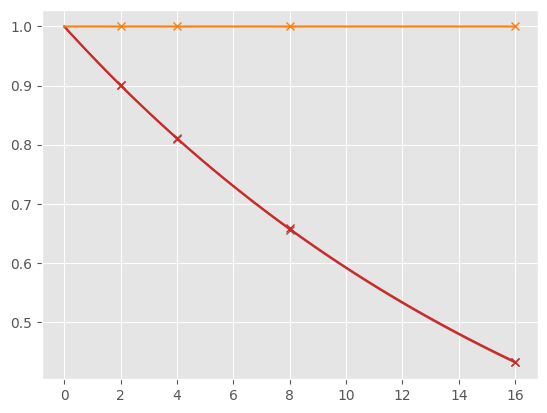

In [193]:
layer1.graph((1,))

<Axes: >

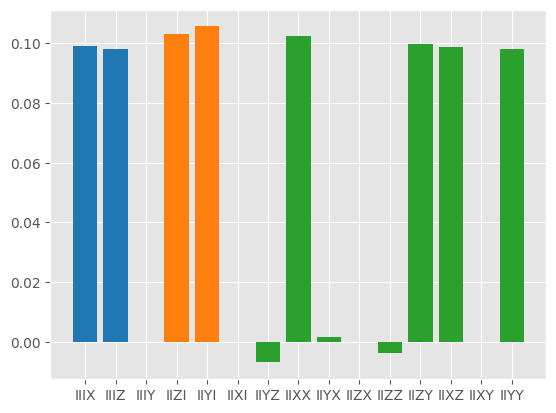

In [194]:
layer1.plot_infidelitites((0,),(1,),(0,1))

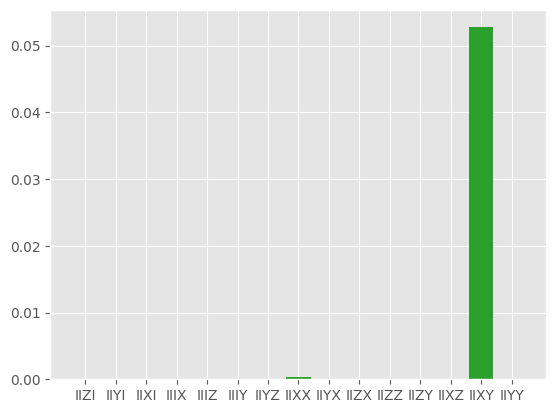

In [195]:
layer1.plot_coeffs((1,),(0,),(0,1))